In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import pandas as pd
import sys 
sys.path.append("../")
from src.misc_utils import *
from src.model_utils import *
from src.sequence_utils import *
from src.data import update,prepare_data
from src.portfolio import *
from yahooquery import Ticker
from datetime import datetime,timedelta
import sqlite3

In [3]:
DATA_DIR="/home/notebooks/"
MODELS_DIR="/home/notebooks/"
DB_PATH="/home/stock_db"
HORIZON=7
PRICE_COLUMN="Close"
LOOKBACK=365*2 ##two years 
HISTORY=14
FORECAST_STEPS=1
FUTURE=0
TARGET=f"log_return_{HORIZON}"

In [4]:
last_date=datetime.today()


In [5]:
data=prepare_data(last_date=last_date,
                  db_path=DB_PATH,
                  price_column=PRICE_COLUMN,
                  lookback=LOOKBACK,
                  horizon=HORIZON,
                  forecast_steps=FORECAST_STEPS,
                  update_data=True,
                  test_ratio=.1,
                  val_ratio=0)

In [32]:
t=Ticker("AAPL")

In [40]:
x=t.history(start="2023-06-13",adj_timezone=False)

In [41]:
x=x.reset_index()

In [47]:
x.date.dt.hour==0

0     True
1    False
Name: date, dtype: bool

In [43]:
x

,symbol,date,open,high,low,close,volume,adjclose
0,AAPL,2023-06-13 00:00:00+00:00,182.800003,184.149994,182.440002,183.309998,54929100,183.309998
1,AAPL,2023-06-14 19:54:54+00:00,183.369995,184.384995,182.020004,183.514999,44415936,183.514999


In [6]:
norm=Normaliser()

In [7]:
norm.build(target="Close",timeseries_id_column="ticker")

In [8]:
norm.fit(data[data.train==1])

In [9]:
data=norm.normalise(data)

In [10]:
data.columns

Index(['date', 'ticker', 'industry', 'Close', 'holiday', 'dow', 'weekend',
       'woy', 'working_day', 'i', 'train', 'test', 'val', 'Close_shift_1',
       'lag_date_Close_1', 'log_return_1', 'log_return_1_shift_-1',
       'lag_date_log_return_1_-1', 'Close_shift_2', 'lag_date_Close_2',
       'log_return_2', 'log_return_2_shift_-2', 'lag_date_log_return_2_-2',
       'Close_shift_3', 'lag_date_Close_3', 'log_return_3',
       'log_return_3_shift_-3', 'lag_date_log_return_3_-3', 'Close_shift_4',
       'lag_date_Close_4', 'log_return_4', 'log_return_4_shift_-4',
       'lag_date_log_return_4_-4', 'Close_shift_5', 'lag_date_Close_5',
       'log_return_5', 'log_return_5_shift_-5', 'lag_date_log_return_5_-5',
       'Close_shift_6', 'lag_date_Close_6', 'log_return_6',
       'log_return_6_shift_-6', 'lag_date_log_return_6_-6', 'Close_shift_7',
       'lag_date_Close_7', 'log_return_7', 'log_return_7_shift_-7',
       'lag_date_log_return_7_-7', 'Close_scaled'],
      dtype='object')

In [11]:
num_features=["Close_scaled",
              "log_return_1_shift_-1",
              "log_return_2_shift_-2",
              "log_return_3_shift_-3",
              "log_return_4_shift_-4",
              "log_return_5_shift_-5",
              "log_return_6_shift_-6",
              "log_return_7_shift_-7",
]

In [12]:
initial_available_date=data[~data[TARGET].isnull()].date.min()

In [13]:
enc=Encoder()

In [14]:
enc.build(categoricals=[
    "industry",
    "ticker",
     "woy",#drop woy ? 
    "dow"
])

In [15]:
enc.fit(data[data.train==1])

In [16]:
enc=Encoder()
enc.load(f"encoder")

In [17]:
features=enc.get_encoded_features()

In [18]:
features=features+num_features

In [19]:
data=enc.apply(data)

In [20]:
inference_date=data[(data.weekend==0)&(data.holiday=="no_holiday")&(data.date>data[~data[TARGET].isnull()][f"lag_date_Close_{HORIZON}"].max())].date.min()

In [21]:
sequencer=TimeseriesSquencer(
    features=features,
    target=TARGET,
    history=HISTORY,
    future=FUTURE,
    steps=FORECAST_STEPS,
    id_column="ticker",
    time_column="date",
    data_end_date=inference_date.strftime("%Y-%m-%d"),
    include_target_feature=False,
    extra_id_columns=[])

In [22]:
train_dict=sequencer.sequence_timeseries(data[data.train==1].dropna())

In [23]:
#val_dict=sequencer.sequence_timeseries(data[data.val==1].dropna())

In [24]:
test_dict=sequencer.sequence_timeseries(data[data.test==1].dropna())

In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                                patience=10,
                                                  restore_best_weights=True,
                                                mode='min') 

In [26]:
def same_sign(y_true,y_pred):
    return tf.reduce_sum(tf.abs(tf.cast(tf.sign(y_true),dtype=tf.float64)+tf.cast(tf.sign(y_pred),dtype=tf.float64))/2)/tf.reduce_sum(tf.abs(tf.cast(tf.sign(y_true),dtype=tf.float64)))

In [27]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(512,use_bias=False,return_sequences=True,kernel_initializer=tf.keras.initializers.glorot_normal(),activation="relu",kernel_regularizer=tf.keras.regularizers.L1(.0)))
model.add(tf.keras.layers.GRU(256,use_bias=False,return_sequences=True,kernel_initializer=tf.keras.initializers.glorot_normal(),activation="relu",kernel_regularizer=tf.keras.regularizers.L1(.0)))
model.add(tf.keras.layers.GRU(128,use_bias=False,return_sequences=True,kernel_initializer=tf.keras.initializers.he_normal(),activation="relu",kernel_regularizer=tf.keras.regularizers.L1(.0)))
model.add(tf.keras.layers.GRU(32,use_bias=False,return_sequences=True,kernel_initializer=tf.keras.initializers.he_normal(),activation="relu",kernel_regularizer=tf.keras.regularizers.L1(.0)))
#model.add(tf.keras.layers.GRU(16,use_bias=False,return_sequences=True,kernel_initializer=tf.keras.initializers.he_normal(),activation="relu",kernel_regularizer=tf.keras.regularizers.L1(.0)))
#model.add(tf.keras.layers.LSTM(8,use_bias=False,return_sequences=True,kernel_initializer=tf.keras.initializers.he_normal(),activation="relu",kernel_regularizer=tf.keras.regularizers.L1(.0)))
model.add(tf.keras.layers.Dropout(rate=.8))

model.add(tf.keras.layers.GRU(5))
#model.add(tf.keras.layers.LSTM(20,use_bias=False,return_sequences=True,kernel_initializer=tf.keras.initializers.glorot_normal()))
#model.add(tf.keras.layers.LSTM(10,use_bias=False,kernel_initializer=tf.keras.initializers.glorot_normal()))

model.add(tf.keras.layers.Dense(units=FORECAST_STEPS,use_bias=True,kernel_initializer=tf.keras.initializers.glorot_normal(),kernel_regularizer=tf.keras.regularizers.L1(.0)))


In [28]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001), loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.RootMeanSquaredError(),same_sign])

In [29]:
history=model.fit(
    train_dict["X"],
    train_dict["Y"],
    validation_split=.2,
    #validation_data=(train_dict["X"], train_dict["Y"]),
    epochs=1000,
    batch_size=60,
    verbose=1,
    callbacks=[early_stopping]) ##0.0554

Epoch 1/1000


2023-06-14 15:31:24.970643: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 367681440 exceeds 10% of free system memory.


890/890 [==============================] - 130s 141ms/step - loss: 0.0035 - root_mean_squared_error: 0.0593 - same_sign: 0.5648 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0640 - val_same_sign: 0.6230
Epoch 2/1000
890/890 [==============================] - 125s 140ms/step - loss: 0.0031 - root_mean_squared_error: 0.0557 - same_sign: 0.6336 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0627 - val_same_sign: 0.6371
Epoch 3/1000
890/890 [==============================] - 125s 140ms/step - loss: 0.0030 - root_mean_squared_error: 0.0545 - same_sign: 0.6504 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0618 - val_same_sign: 0.6438
Epoch 4/1000
890/890 [==============================] - 125s 140ms/step - loss: 0.0029 - root_mean_squared_error: 0.0535 - same_sign: 0.6604 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0614 - val_same_sign: 0.6469
Epoch 5/1000
890/890 [==============================] - 126s 141ms/step - loss: 0.0028 - root_mean_squared_error: 0.0527 - sa

In [30]:
model.evaluate(test_dict["X"], test_dict["Y"])#[0.0017741959309205413, 0.04212120547890663, 0.5632179379463196]

177/177 [==============================] - 6s 33ms/step - loss: 0.0053 - root_mean_squared_error: 0.0730 - same_sign: 0.5106


[0.00533090066164732, 0.07301301509141922, 0.5105818510055542]

In [31]:
inference_date

Timestamp('2023-06-15 00:00:00')

In [32]:
model.save(f"model-{inference_date.strftime('%Y-%m-%d')}")

INFO:tensorflow:Assets written to: model-2023-06-14/assets


INFO:tensorflow:Assets written to: model-2023-06-14/assets


In [ ]:
norm.save(f"model-{inference_date.strftime('%Y-%m-%d')}/normaliser")

enc.save(f"model-{inference_date.strftime('%Y-%m-%d')}/encoder")

In [50]:
tmp=data[(data.test==1)&(data.working_day==1)].copy()

In [51]:
result=get_predictions(model,tmp,test_dict,steps=[0])

177/177 [==============================] - 7s 33ms/step


In [52]:
rmse = lambda x,y:np.sqrt(np.mean((x-y)**2))

<AxesSubplot: xlabel='date'>

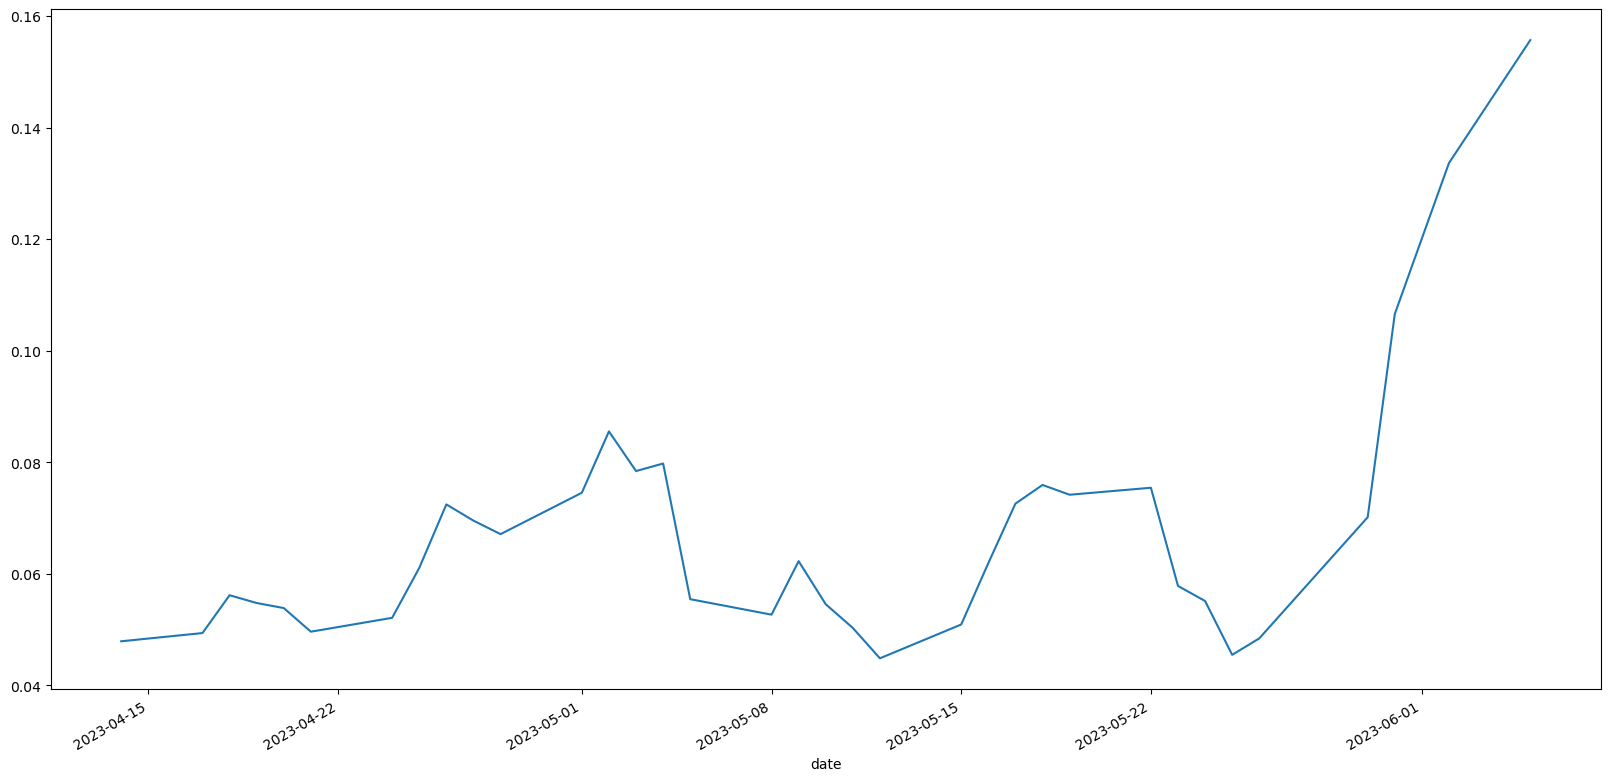

In [54]:
result.groupby("date").apply(lambda x: rmse(x[TARGET],x["pred_step_0"])).sort_values().plot(figsize=(20,10))

In [55]:
rmse_quality=result.dropna().groupby("ticker")[[TARGET,"pred_step_0"]].apply(lambda x: rmse(x.tail(30)[TARGET],x.tail(30)["pred_step_0"])).sort_values()

<AxesSubplot: ylabel='Frequency'>

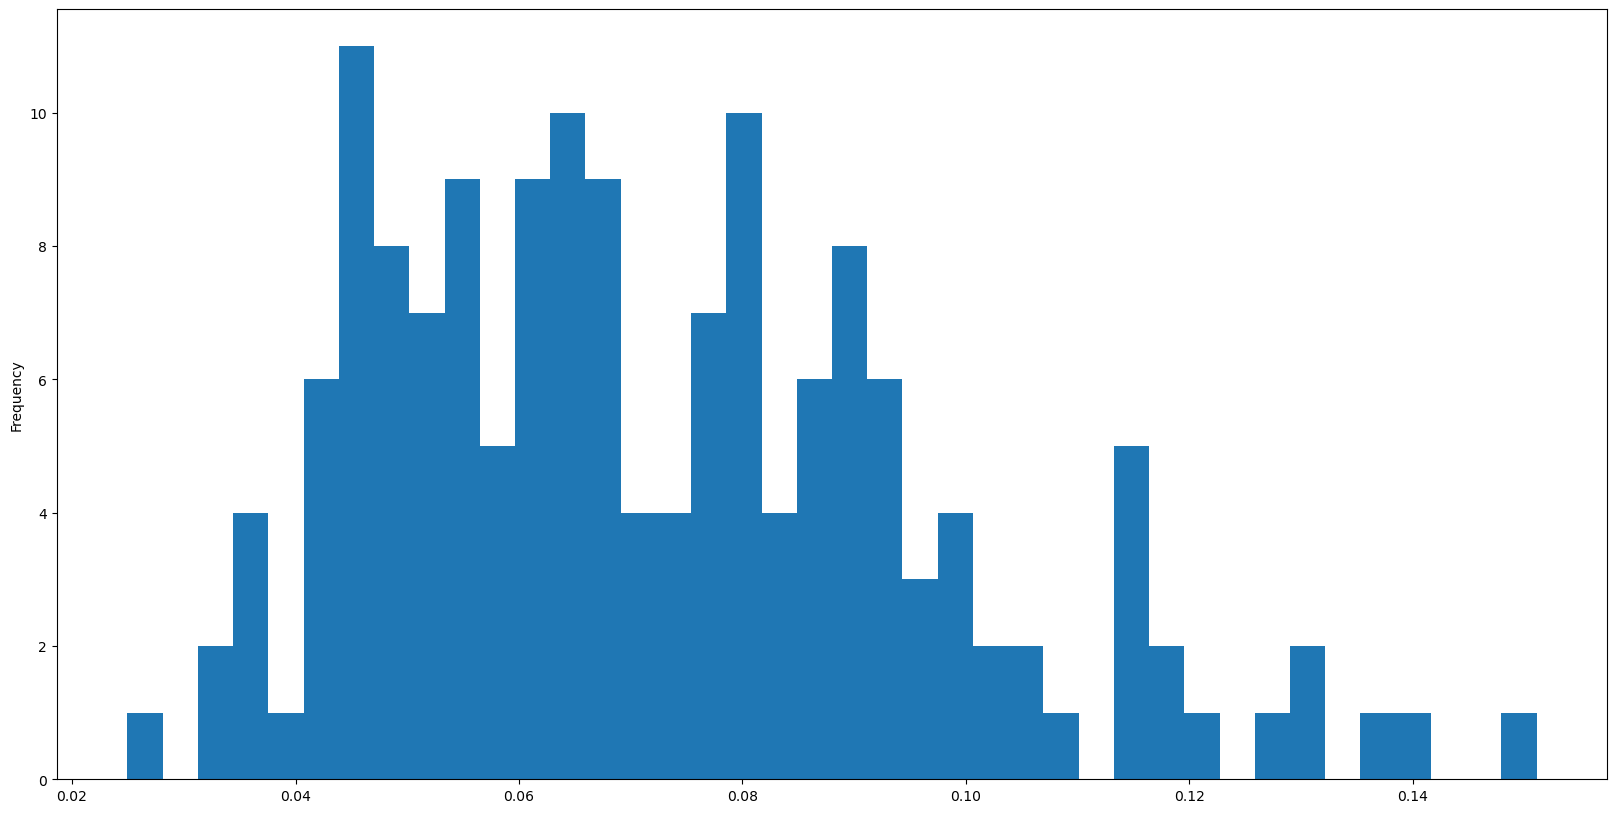

In [59]:
rmse_quality.plot.hist(bins=40,figsize=(20,10))

In [60]:
result["zero"]=0

<AxesSubplot: >

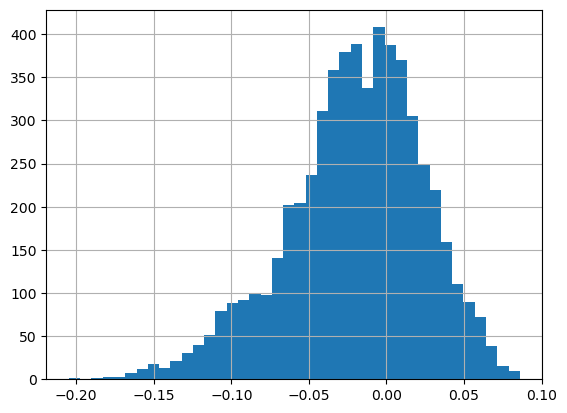

In [61]:
result.pred_step_0.hist(bins=40)

<AxesSubplot: >

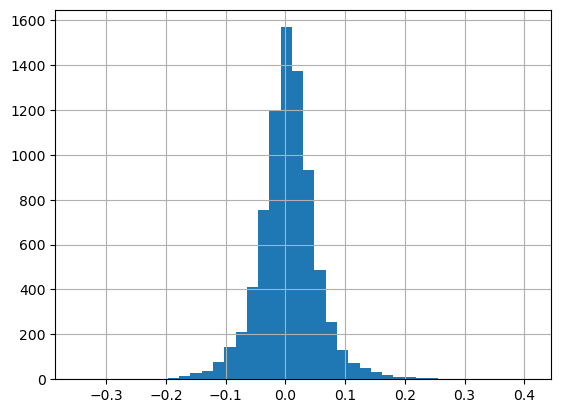

In [62]:
result.log_return_7.hist(bins=40)

<AxesSubplot: xlabel='date'>

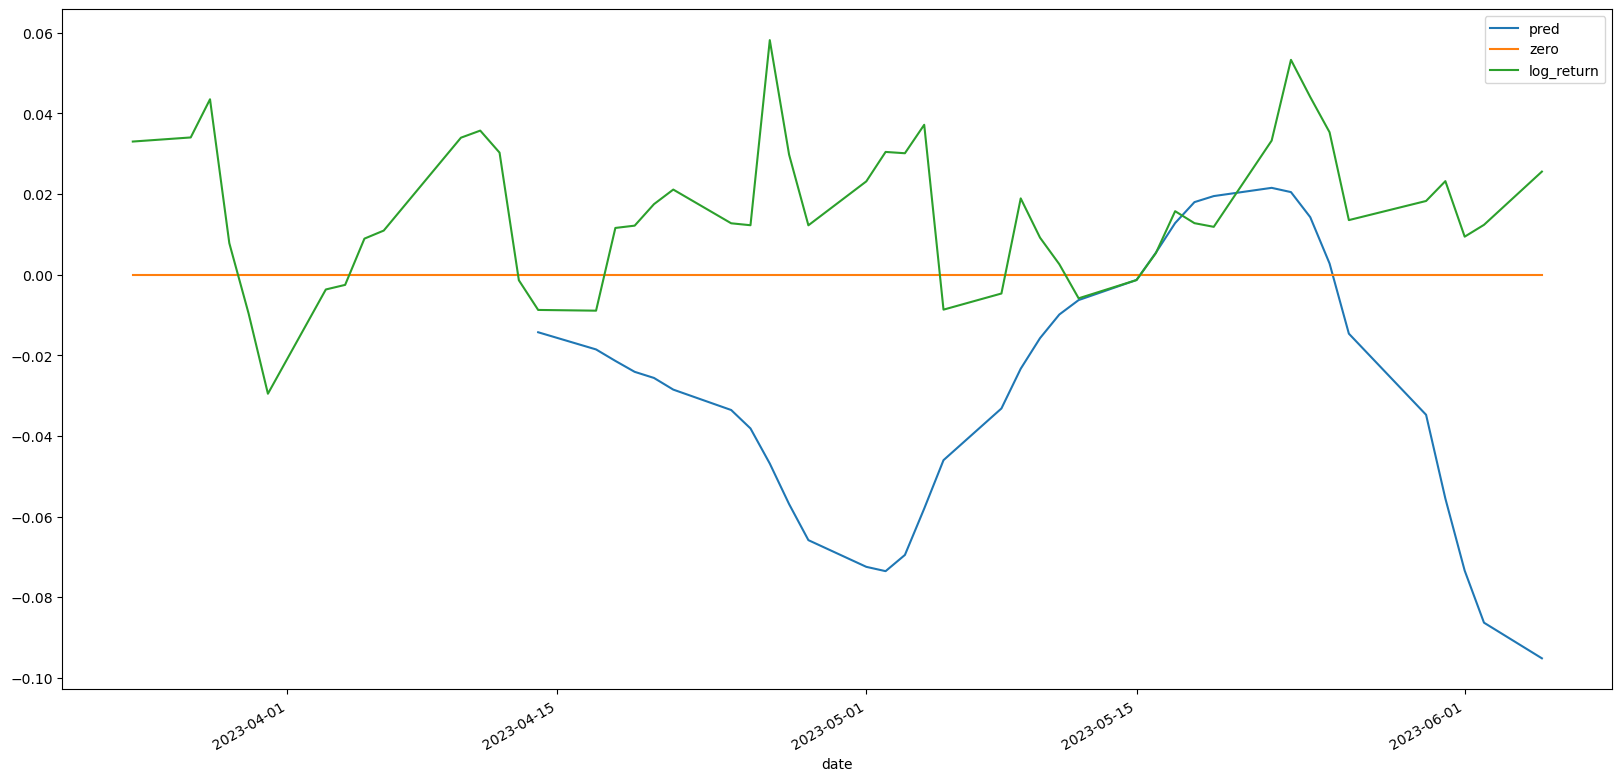

In [63]:
result[result.ticker=="AAPL"].groupby("date").agg(pred=("pred_step_0","mean"),zero=("zero","mean"),log_return=(TARGET,"mean")).plot(figsize=(20,10))

In [64]:
result

,date,ticker,industry,Close,holiday,dow,weekend,woy,working_day,i,...,woy_49,woy_50,woy_51,woy_52,dow_1,dow_2,dow_3,dow_4,pred_step_0,zero
0,2023-03-24,AAPL,Consumer Electronics,160.250000,no_holiday,4,0,12,1,446.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0
1,2023-03-27,AAPL,Consumer Electronics,158.279999,no_holiday,0,0,13,1,447.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0
2,2023-03-28,AAPL,Consumer Electronics,157.649994,no_holiday,1,0,13,1,448.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0
3,2023-03-29,AAPL,Consumer Electronics,160.770004,no_holiday,2,0,13,1,449.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0
4,2023-03-30,AAPL,Consumer Electronics,162.360001,no_holiday,3,0,13,1,450.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7895,2023-05-30,ZG,Internet Content & Information,43.900002,no_holiday,1,0,22,1,491.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000599,0
7896,2023-05-31,ZG,Internet Content & Information,44.790001,no_holiday,2,0,22,1,492.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.033001,0
7897,2023-06-01,ZG,Internet Content & Information,45.150002,no_holiday,3,0,22,1,493.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.063273,0
7898,2023-06-02,ZG,Internet Content & Information,45.759998,no_holiday,4,0,22,1,494.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.084109,0


<AxesSubplot: xlabel='date'>

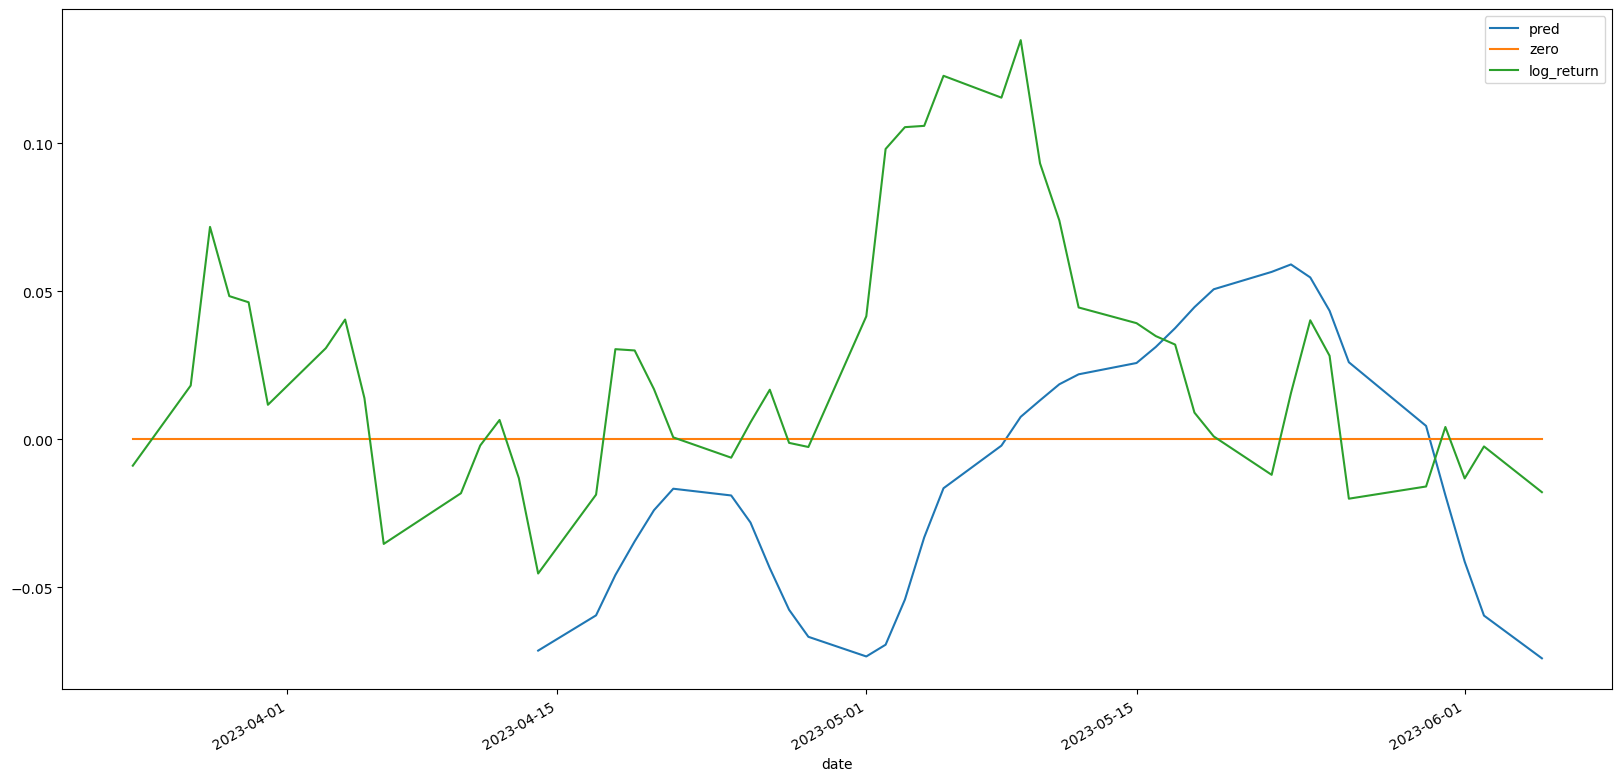

In [68]:
result[result.ticker=="GOOG"].groupby("date").agg(pred=("pred_step_0","mean"),zero=("zero","mean"),log_return=(TARGET,"mean")).plot(figsize=(20,10))

<AxesSubplot: xlabel='date'>

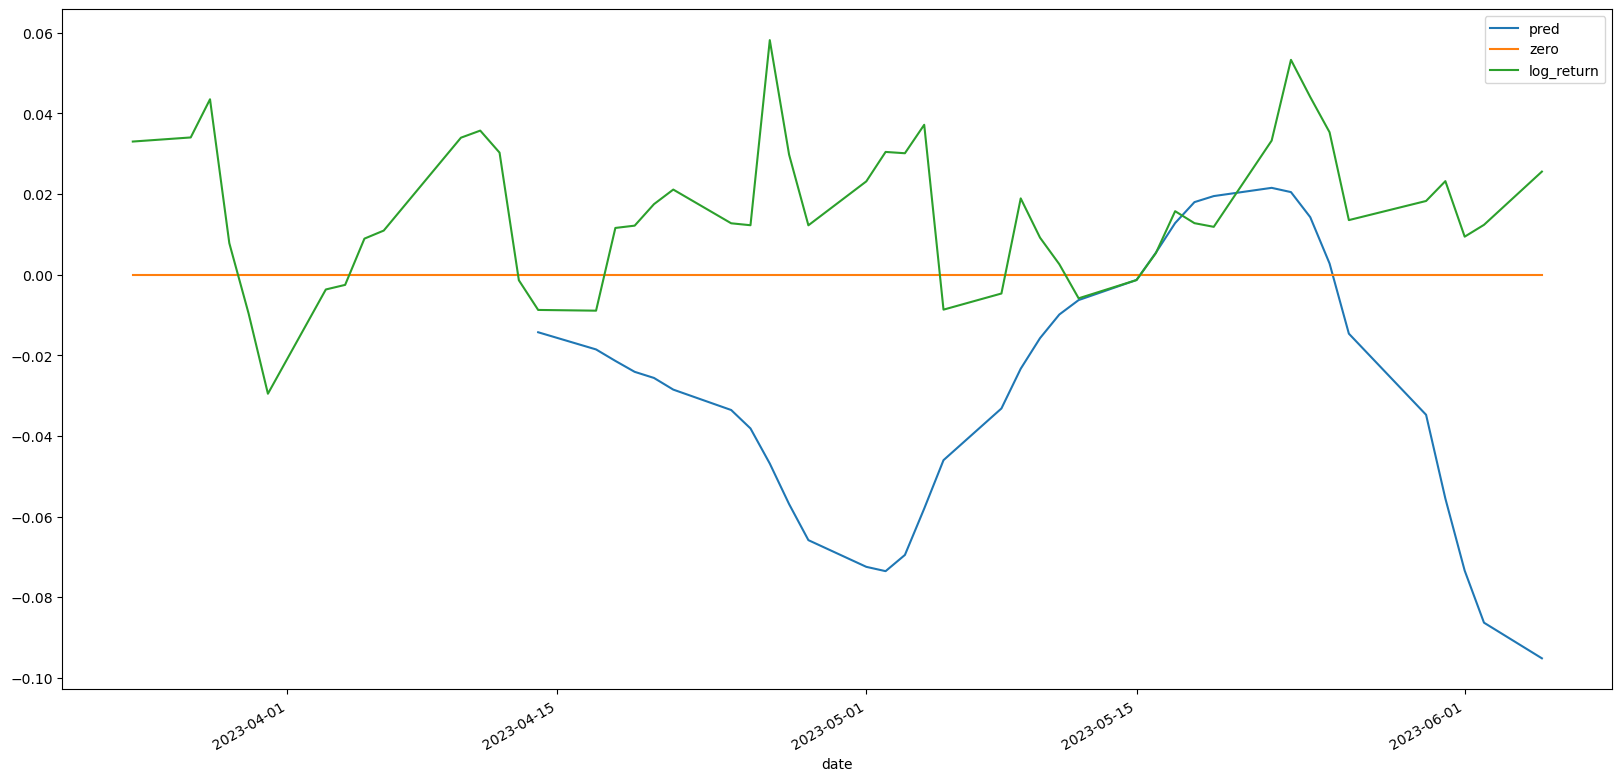

In [67]:
result[result.ticker=="AAPL"].groupby("date").agg(pred=("pred_step_0","mean"),zero=("zero","mean"),log_return=(TARGET,"mean")).plot(figsize=(20,10))

<AxesSubplot: xlabel='date'>

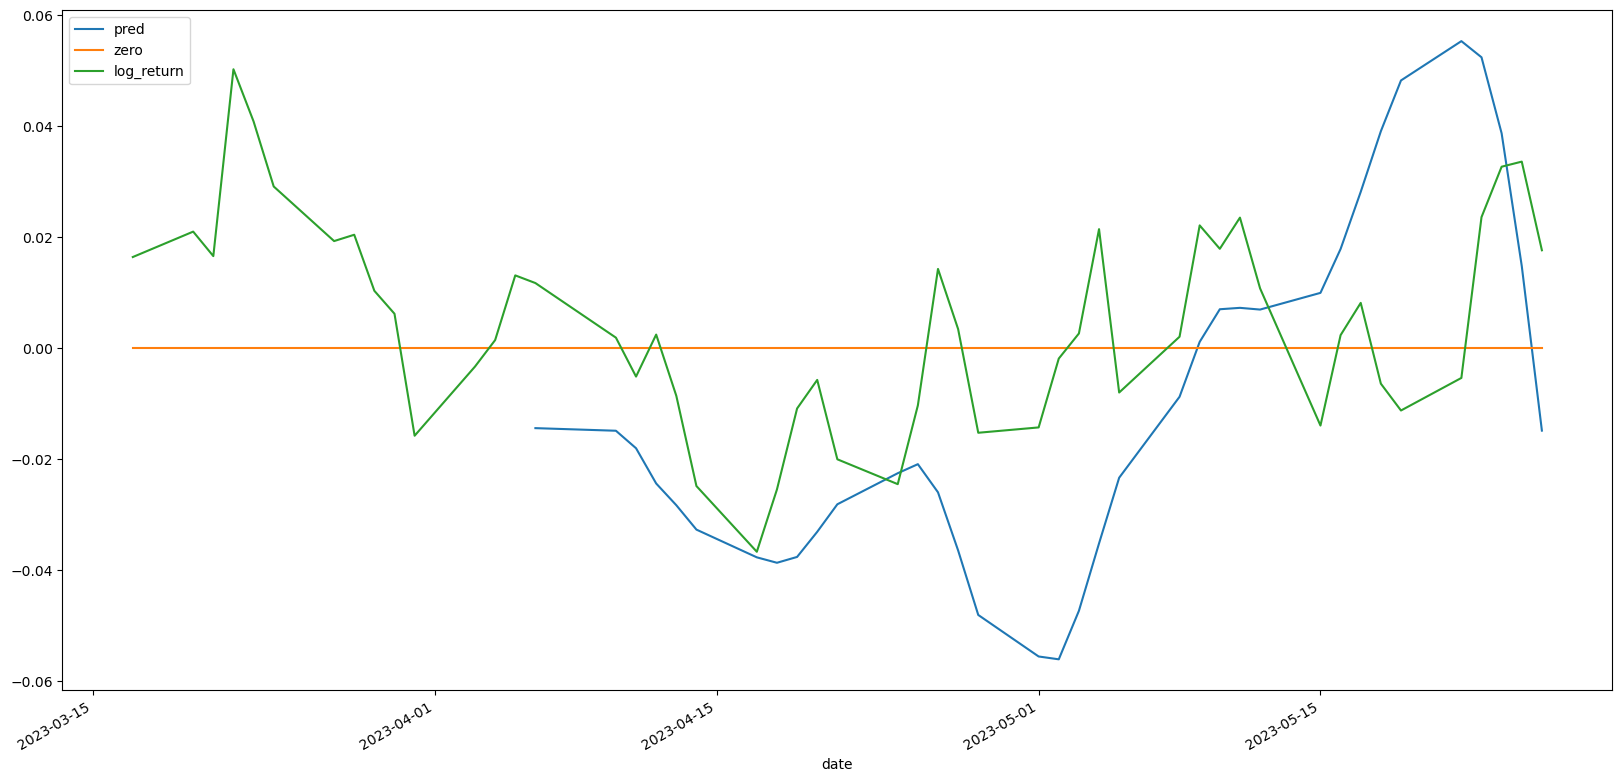

In [63]:
result.groupby("date").agg(pred=("pred_step_0","mean"),zero=("zero","mean"),log_return=(TARGET,"mean")).plot(figsize=(20,10))

In [64]:
date="2023-05-30"
RISK_LEVEL=0.01

In [65]:
MIN_BUDGET=50
MAX_BUDGET=500

In [66]:
## PREDICTED CLOSE FOR NEXT TRADING DAY
result=shift(result,lag=-1,column="Close")

In [67]:
expected_price="Close_shift_-1"

In [68]:
import datetime
today=datetime.datetime.today()

In [69]:
#result=result[result.date<=today]

In [70]:
tickers=result.ticker.unique()

In [80]:
MIN_BUDGET=0
MAX_BUDGET=1000
CNT_EXPERIMENTS=10

In [81]:
dates=[]
investments=[]
value_at_risk=[]
predicted_returns=[]
actual_returns=[]
maturity_date=[]
for date in result[result.date<=inference_date].date.unique()[-HORIZON-CNT_EXPERIMENTS:-HORIZON]:
    print(date)
    res,opt_tickers=optimise(prediction_results=result,
                 date=date,
                 min_budget=MIN_BUDGET,
                 max_budget=MAX_BUDGET,
                 tickers=tickers,
                 max_value_at_risk=10,
                 log_return_column=TARGET,
                 predicted_log_return_column="pred_step_0",
                 expected_price_column='Close_shift_-1',diversity=.99)
    dates.append(date)
    maturity_date.append(result[result.date==date]["lag_date_Close_7"].unique()[0])
    investments.append(investment(opt_tickers,res,result,price_column=PRICE_COLUMN,buy_date=date))
    investment(opt_tickers,res,result,price_column=PRICE_COLUMN,buy_date=date)
    value_at_risk.append(compute_value_at_risk(data=result,tickers=opt_tickers, 
                                                shares=res, buy_date=date, price_column='Close_shift_-1', 
                                                                                   log_return_column=TARGET,
                                                                                   confidence_level=0.99))
    predicted_returns.append(portfolio_buy_date_return(tickers=opt_tickers,shares=res,stock_log_return=result,buy_date=date,price_column='Close_shift_-1',log_return_column="pred_step_0"))
    actual_ret=portfolio_buy_date_return(tickers=opt_tickers,shares=res,stock_log_return=result,buy_date=date,price_column=PRICE_COLUMN,log_return_column=TARGET)
    print(actual_ret)
    actual_returns.append(actual_ret)
    
    

2023-05-11 00:00:00+00:00
Dropping the following ticker []
0.0797503658164393
2023-05-12 00:00:00+00:00
Dropping the following ticker []
0.052749339899166144
2023-05-15 00:00:00+00:00
Dropping the following ticker []
0.04863341009543696
2023-05-16 00:00:00+00:00
Dropping the following ticker []
0.014126422675066025
2023-05-17 00:00:00+00:00
Dropping the following ticker []
0.0393513467265035
2023-05-18 00:00:00+00:00
Dropping the following ticker []
0.029924931062267717
2023-05-19 00:00:00+00:00
Dropping the following ticker []
0.03653626053260678
2023-05-22 00:00:00+00:00
Dropping the following ticker []
0.04140328319589035
2023-05-23 00:00:00+00:00
Dropping the following ticker []
0.05539982126150652
2023-05-24 00:00:00+00:00
Dropping the following ticker []
-inf


/home/notebooks/src/portfolio.py:18: RuntimeWarning: divide by zero encountered in log
  portfolio_log_return = np.log(np.sum(tmp['weight'] * np.exp(tmp[log_return_column])))


In [82]:
opt=pd.DataFrame()

In [83]:
opt["date"]=dates
opt["maturity_date"]=maturity_date
opt["investments"]=investments
opt["value_at_risk"]=value_at_risk
opt["predicted_returns"]=predicted_returns
opt["actual_returns"]=actual_returns

In [84]:
opt["expected_gain"]=(np.exp(opt.predicted_returns)-1)*opt.investments
opt["actual_gain"]=(np.exp(opt.actual_returns)-1)*opt.investments

In [85]:
opt

,date,investments,value_at_risk,predicted_returns,actual_returns,expected_gain,actual_gain
0,2023-05-11 00:00:00+00:00,45.725816,4.843961,0.023667,0.079750,1.095088,3.796005
1,2023-05-12 00:00:00+00:00,57.451560,7.660252,0.029688,0.052749,1.731171,3.111885
2,2023-05-15 00:00:00+00:00,62.473762,9.627969,0.037685,0.048633,2.399269,3.113406
3,2023-05-16 00:00:00+00:00,64.734744,9.864168,0.046312,0.014126,3.068500,0.920960
4,2023-05-17 00:00:00+00:00,60.296749,9.190959,0.053860,0.039351,3.336639,2.420062
5,2023-05-18 00:00:00+00:00,65.558717,9.949910,0.058527,0.029925,3.951436,1.991489
6,2023-05-19 00:00:00+00:00,50.282348,7.937208,0.060672,0.036536,3.145203,1.871102
7,2023-05-22 00:00:00+00:00,100.058137,9.969078,0.062276,0.041403,6.429346,4.229693
8,2023-05-23 00:00:00+00:00,100.309677,9.981920,0.061520,0.055400,6.364853,5.713953
9,2023-05-24 00:00:00+00:00,98.994930,9.756829,0.052879,-inf,5.375586,-98.994930


In [101]:
(127.24*0.0041+0.2040*517.37)/(121.64*0.0041+0.2040*486.55)

1.0632574287761474

In [99]:
date

Timestamp('2023-05-24 00:00:00+0000', tz='UTC')

In [95]:
result[result.date==date]["lag_date_Close_7"].unique()[0]

Timestamp('2023-06-05 00:00:00+0000', tz='UTC')

In [679]:
opt.sort_values("predicted_returns")

,date,investments,value_at_risk,predicted_returns,actual_returns,expected_gain,actual_gain
6,2023-04-28,94.299609,6.062994,0.009327,0.010373,0.883629,0.983294
5,2023-04-27,92.076018,5.769679,0.009469,-0.014464,0.876030,-1.322214
7,2023-05-01,99.486469,5.664391,0.009593,0.040661,0.958936,4.128601
8,2023-05-02,102.970688,5.163283,0.009882,0.046193,1.022644,4.868100
4,2023-04-26,85.735222,5.715652,0.010206,0.013813,0.879458,1.192472
9,2023-05-03,108.777089,4.908646,0.010966,0.036354,1.199426,4.027255
3,2023-04-25,81.221009,5.869288,0.012276,0.004335,1.003216,0.352857
10,2023-05-04,106.063626,4.519701,0.013440,0.024856,1.435154,2.669363
2,2023-04-24,76.650675,5.596539,0.015102,-0.020510,1.166337,-1.556102
11,2023-05-05,108.119102,4.491171,0.017309,-0.004375,1.887745,-0.471943


In [686]:
opt.actual_gain.sum()

9.983229440507854

In [680]:
opt.actual_gain.sum()

-5.526234056041606

In [163]:
res,opt_tickers=optimise(prediction_results=result,
             date=date,
             min_budget=MIN_BUDGET,
             max_budget=MAX_BUDGET,
             tickers=tickers,
             risk_level=RISK_LEVEL,
             predicted_log_return_column="pred_step_0",
             expected_price_column=expected_price)

Dropping the following ticker ['PPCB']


In [164]:
portfolio=pd.DataFrame([opt_tickers,res]).transpose()
portfolio.columns=["ticker","shares"]
portfolio=result[result.date==date][["ticker","Close"]].merge(portfolio,on="ticker",how="right")

<AxesSubplot: xlabel='ticker'>

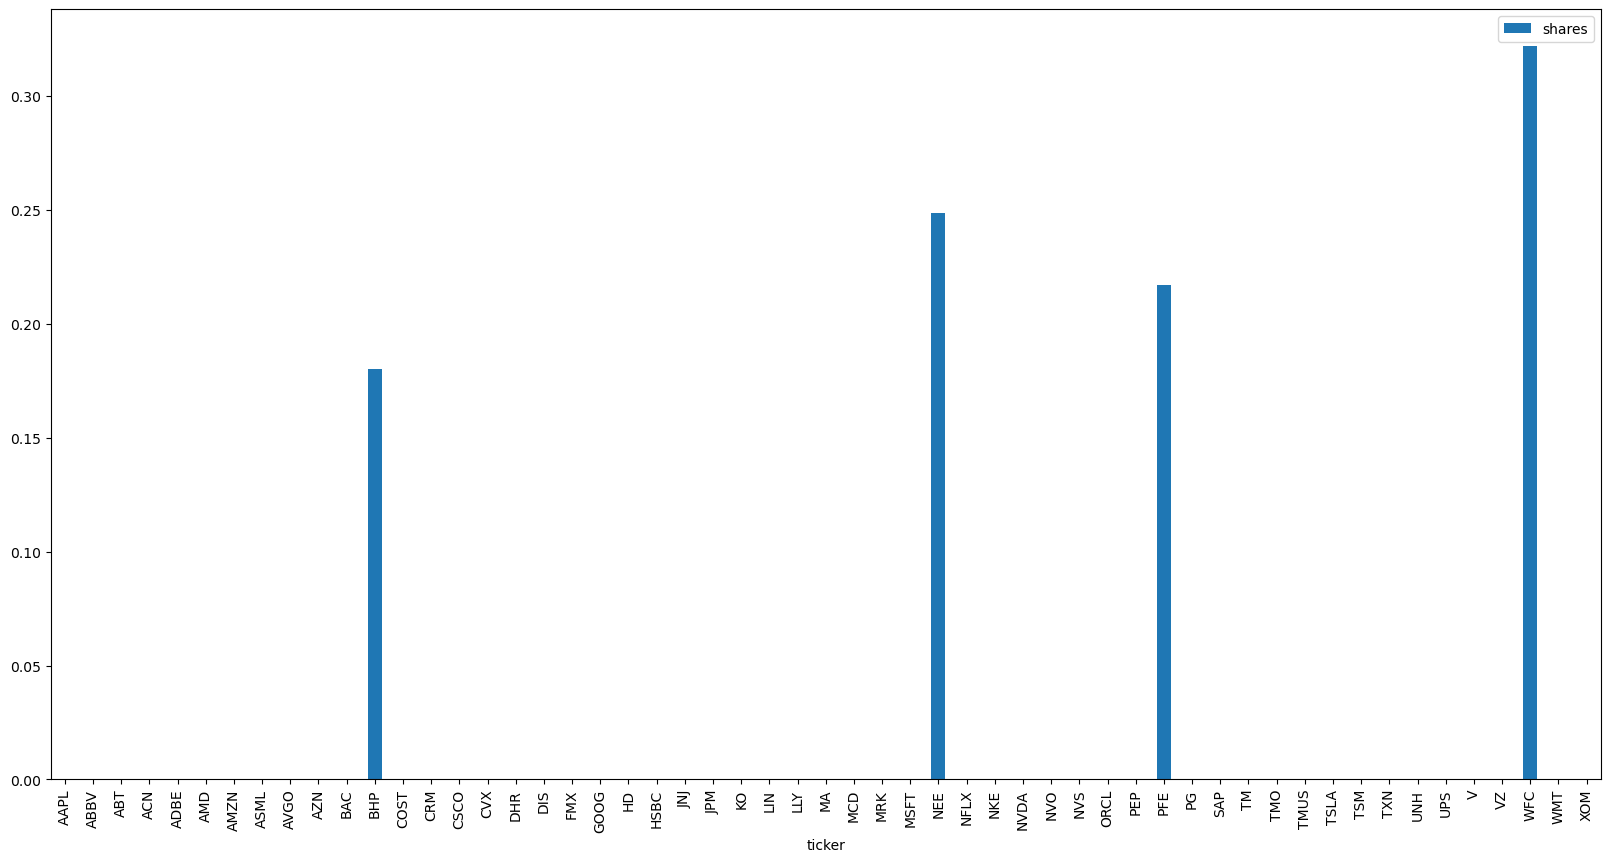

In [165]:
portfolio.plot.bar(x="ticker",y="shares",figsize=(20,10))

In [111]:
result[result.date<=inference_date].date.unique()[-17:-7]

array(['2023-05-05T00:00:00.000000000', '2023-05-08T00:00:00.000000000',
       '2023-05-09T00:00:00.000000000', '2023-05-10T00:00:00.000000000',
       '2023-05-11T00:00:00.000000000', '2023-05-12T00:00:00.000000000',
       '2023-05-15T00:00:00.000000000', '2023-05-16T00:00:00.000000000',
       '2023-05-17T00:00:00.000000000', '2023-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [392]:
portfolio=pd.DataFrame([opt_tickers,res]).transpose()
portfolio.columns=["ticker","shares"]
portfolio=result[result.date==date][["ticker","Close_shift_-1"]].merge(portfolio,on="ticker",how="right")

In [393]:
portfolio

,ticker,Close_shift_-1,shares
0,AAPL,175.429993,0.0
1,ABBV,137.559998,0.0
2,ABT,102.870003,0.0
3,ACN,303.600006,0.0
4,ADBE,415.390015,0.0
5,AMD,127.029999,0.0
6,AMZN,120.110001,0.0
7,ASML,735.929993,0.0
8,AVGO,812.729980,0.0
9,AZN,72.519997,0.0


In [397]:
result.maturity_date.max()

Timestamp('2023-05-18 00:00:00')

In [151]:
def maximize_portfolio_return(tickers, stock_log_return, buy_date, price_column, log_return_column="log_return", budget=1.0):
    # Filter stock_log_return based on buy_date
    tmp = stock_log_return[stock_log_return['date'] == buy_date].copy()

    # Create a DataFrame for ticker shares
    ticker_shares = pd.DataFrame({'ticker': tickers})

    # Merge ticker_shares with filtered stock_log_return
    tmp = tmp.merge(ticker_shares, on='ticker', how='left')

    # Calculate value and budget for each date
    tmp['value'] = budget * tmp[price_column]
    tmp['budget'] = tmp['value'].sum()

    # Calculate the weight for each row
    tmp['weight'] = tmp['value'] / tmp['budget']

    # Calculate the expected log return
    expected_log_return = np.sum(tmp['weight'] * tmp[log_return_column])

    # Calculate the covariance matrix
    cov_matrix = np.cov(tmp[log_return_column], rowvar=False)

    # Define the objective function to maximize portfolio return
    def objective(weight):
        portfolio_return = np.sum(weight * tmp[log_return_column])
        return -portfolio_return

    # Define the constraint function to ensure the sum of weights is 1 and weights are non-negative
    def constraint(weight):
        return np.concatenate((np.sum(weight) - 1.0, -weight))

    # Set the bounds for each weight (0 <= weight <= 1)
    bounds = [(0, None)] * len(tickers)

    # Set the initial guess for weights (equal allocation)
    init_guess = [1 / len(tickers)] * len(tickers)

    # Define the optimization problem
    opt_problem = {'type': 'eq', 'fun': constraint}
    opt_result = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=opt_problem)

    # Retrieve the optimal weights
    optimal_weights = opt_result.x

    # Calculate the portfolio return with optimal weights
    portfolio_return = np.sum(optimal_weights * tmp[log_return_column])

    return optimal_weights, portfolio_return

In [141]:
res,expected_return=maximize_portfolio_return(tickers=tickers, stock_log_return=result[result.ticker.isin(tickers)], buy_date="2023-03-01", price_column="Close_shift_-1", log_return_column="pred_step_0", budget=1.0)

In [142]:
expected_return

0.01582266522851775

In [143]:
portfolio_buy_date_return(tickers=tickers,shares=res,stock_log_return=result,buy_date="2023-03-01",price_column='Close',log_return_column="log_return")

0.007019564560666403